In [1]:
include("../../utils/IFMAB3.jl")
include("../RotatingShallowWater.jl")
include("../RSWUtils.jl")
using JLD2
using CairoMakie
using FourierFlows
using AbstractFFTs

In [18]:
test_file = "/scratch/nad9961/rsw/51962610/8/rsw.000001.jld2"
file = jldopen(test_file, "r")
N = length(keys(file["snapshots/sol"]))
println(N)
U = zeros(Complex{Float32}, N)
f_idx = 1
params = (f = 3, Cg2 = 1.0)
grid = TwoDGrid(;nx=512, Lx=2π)

Φ₀, Φ₊, Φ₋ = compute_balanced_wave_bases(grid, params)
ts = zeros(N)
energy1 = zeros(N)
energy2 = zeros(N)
wave_energy1 = zeros(N)
wave_energy2 = zeros(N)
for i=1:N
    idx = keys(file["snapshots/sol/"])[i]
    snapshot = file["snapshots/sol/" * idx]
    c0, c1, c2 = compute_balanced_wave_weights(snapshot[:,:,1], snapshot[:,:,2], snapshot[:,:,3], Φ₀, Φ₊, Φ₋)
    ((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(snapshot[:,:,1], snapshot[:,:,2], snapshot[:,:,3], grid, params)
    ts[i] = file["snapshots/t/" * idx]
    energy1[i] = sum(abs2.(snapshot[:,:,1]) + abs2.(snapshot[:,:,2]) + params.Cg2*abs2.(snapshot[:,:,3]))
    energy2[i] = sum(abs2.(c0) + abs2.(c1) + abs2.(c2))
    wave_energy1[i] = sum(abs2.(uwh) + abs2.(vwh) + params.Cg2*abs2.(ηwh))
    wave_energy2[i] = sum(abs2.(c1) + abs2.(c2))
end

close(file)

100


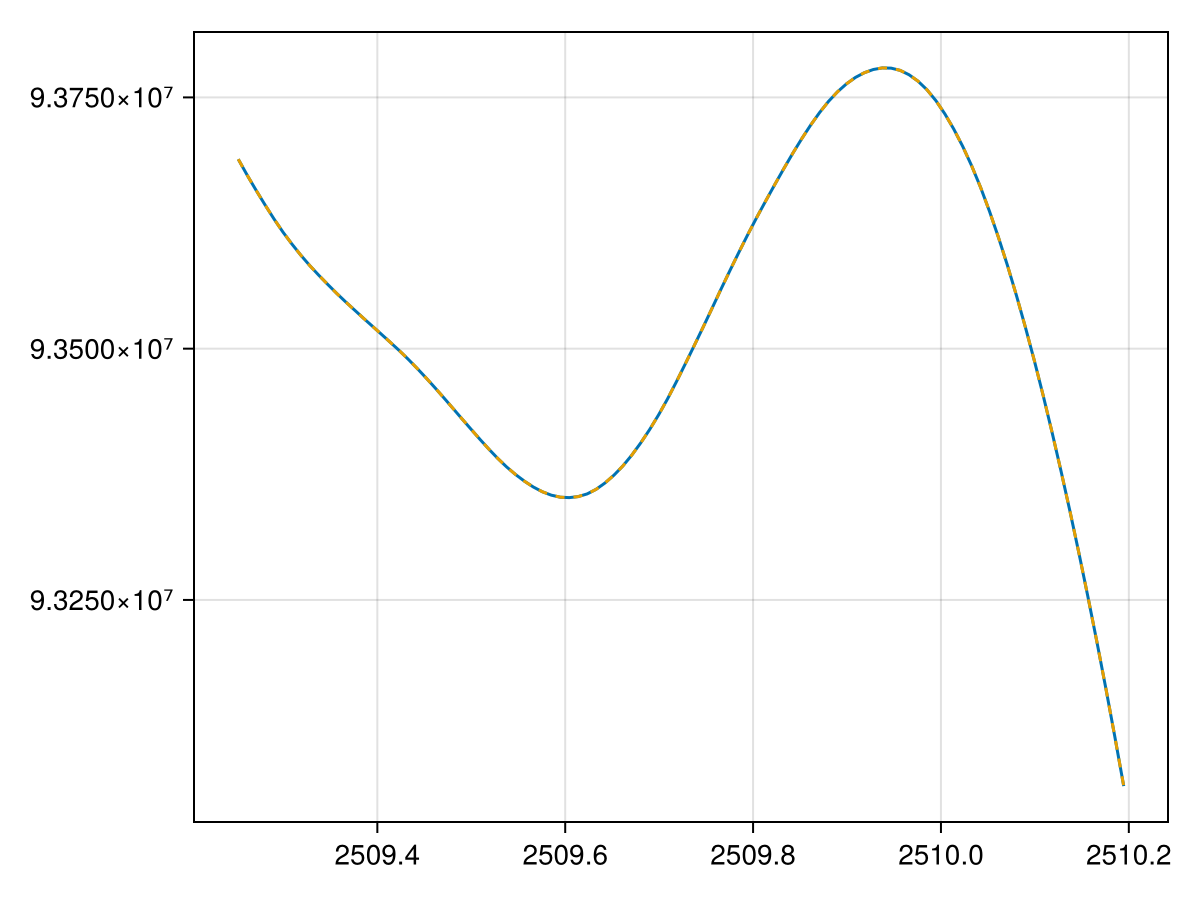

In [19]:
fig = Figure()
ax = Axis(fig[1,1])
lines!(ax, ts, wave_energy1)
lines!(ax, ts, wave_energy2, linestyle=:dash)

fig

In [78]:
geo_energy1  = abs2.(ugh) + abs2.(vgh) + abs2.(ηgh)
wave_energy1 = abs2.(uwh) + abs2.(vwh) + abs2.(ηwh) 
geo_energy2 = abs2.(c0)
wave_energy2p = abs2.(c1)
wave_energy2n = abs2.(c2)
total_energy1 = geo_energy1 + wave_energy1
total_energy2 = geo_energy2 + wave_energy2p + wave_energy2n
tol = 1e-16
println(maximum(abs.((wave_energy1 - wave_energy2p - wave_energy2n)./(wave_energy1 .+ tol))))
println(maximum(abs.((geo_energy1 - geo_energy2)./(geo_energy2 .+ tol))))
println(maximum(abs.((total_energy1 - total_energy2)./(total_energy2 .+ tol))))

1.6280091194590627e-14
5.516616563399251e-6
6.090434621571168e-8


In [76]:
maximum((geo_energy1 - geo_energy2) ./ (geo_energy2 .+ 1e-16))

3.391847053350612e-6

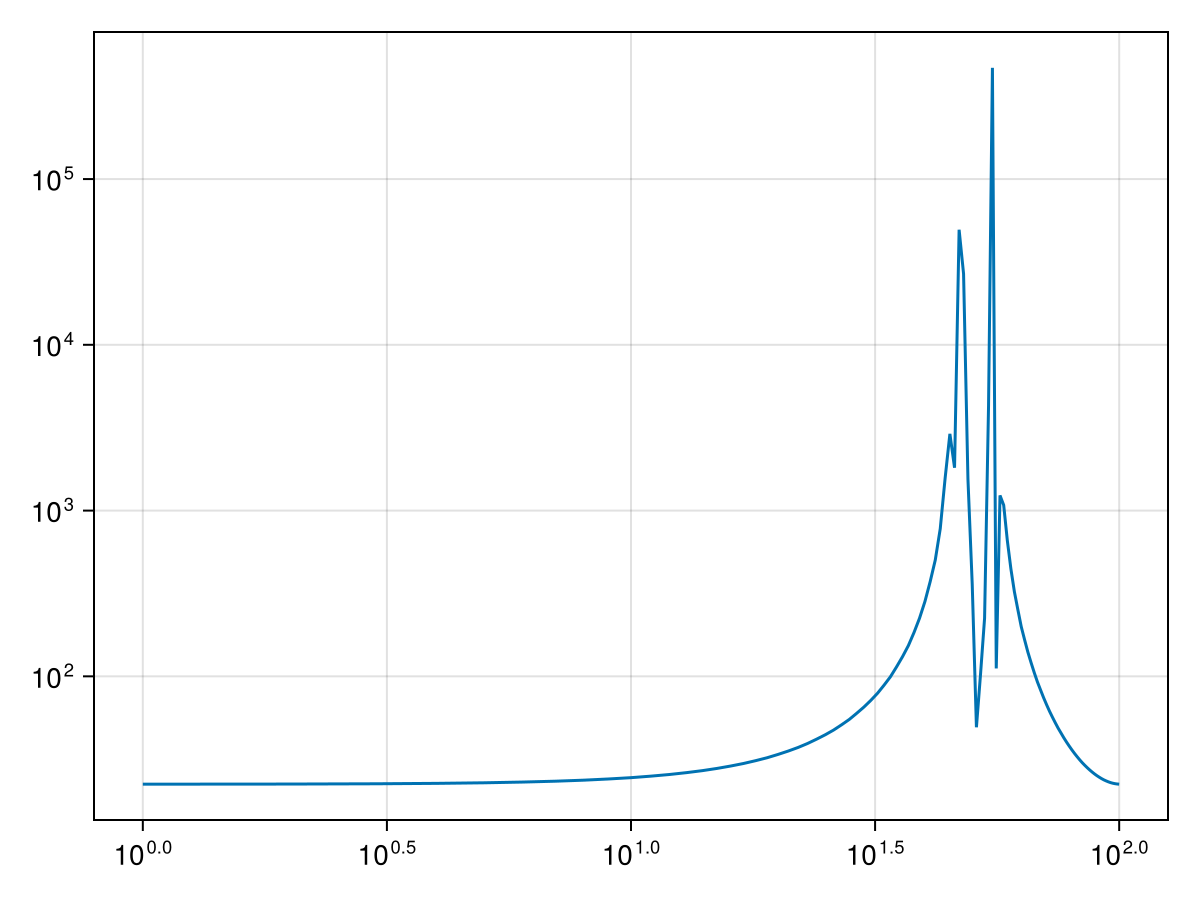

In [27]:
ω = 
lines(fftshift(abs2.(fft(U))); axis=(;xscale=log10, yscale=log10))

In [7]:
fullsteppername = Symbol("IFMAB3", :TimeStepper)
expr = Expr(:call, fullsteppername)

# Add keyword arguments    
#length(kw) > 0 && push!(expr.args, Tuple(Expr(:kw, p.first, p.second) for p in kw)...)

:(IFMAB3TimeStepper())

In [16]:
l = 5
k = 2
Cg = sqrt(params.Cg2)
ω = sqrt(params.f^2 + params.Cg2*(k^2 + l^2))
x1 = [-1im * l * Cg / ω, 1im * k * Cg / ω, params.f / ω]
x1

3-element Vector{ComplexF64}:
                 0.0 - 0.8111071056538127im
                 0.0 + 0.3244428422615251im
 0.48666426339228763 + 0.0im

In [23]:
Φ₀[3, 6, :]

3-element Vector{ComplexF64}:
 0.48666426339228763 + 0.0im
  0.7069765842515415 + 0.0im
                 0.0 + 0.0im

In [24]:
grid.l[3]

2.0